Steps:
1. Data preperation
2. Batching
3. Define model from scratch
4. Create seq2seq language model - main model class to produce logits
5. Training loop
6. Plot
7. Prediction

In [1]:
import torch
import matplotlib.pyplot as plt
from collections import Counter

1. Data prep
    - Get data
    - lowercase
    - tokenize
    - create vocab
    - add '<unk>' token for out of vocab words
    - numericalize tokens
    - split data


In [2]:
# get data and lowercase it
with open('timemachine.txt') as f:
    text = f.read().lower()

# tokenize
tokens = text.split()

# create vocab and add <unk> token for out of vocab handling
token_counts = Counter(tokens)
vocab = ['<unk>']+ [word for word, count in token_counts.items() if count >= 3]

# get vocab idx for numericalization
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

# numericalize tokens
num_tokens = [word2idx.get(token, word2idx['<unk>']) for token in tokens]

# split data
split_len = int(len(num_tokens)*0.9)
train_data = num_tokens[:split_len]
val_data = num_tokens[split_len:]


2. batching

We are creating sequences for a language model that predicts the next word. The input sequence is a contiguous block of `seq_length` words, and the target is the same sequence but shifted by one word.

For example, consider the text: "I have a dream that one day" and let `seq_length=5`.

- The first input sequence would be: ["I", "have", "a", "dream", "that"]

- The corresponding target sequence would be: ["have", "a", "dream", "that", "one"]

We do this for every possible contiguous block of `seq_length+1` words (we need one extra for the target). Then we split the block into:

- Input: first `seq_length` words

- Target: last `seq_length` words (which are the next word for each position in the input)

In the code snippet:

```python

x = data[:, i:i+seq_length]   # shape: (batch_size, seq_length)

y = data[:, i+1:i+seq_length+1] # shape: (batch_size, seq_length)
```

By using a shifted sequence for the target, we are effectively training the model to predict the next word at every position. This is called **teacher forcing** and is standard for training language models.

In [3]:
# create batches
def create_batches(data,batch_size, seq_len):
    num_batches = len(data) // (batch_size*seq_len)
    data = data[:num_batches* batch_size* seq_len]
    data = torch.tensor(data).view(batch_size, -1)

    # create input-target samples for each batch
    for i in range(0, data.size(1)-seq_len, seq_len):
        x = data[:, i:i+seq_len]
        y = data[:, i+1: i+seq_len+1]
        yield x, y


In [4]:
for x, y in create_batches(train_data, 10, 3):
    print(x, y)
    print(x.shape, y.shape)
    break

tensor([[   1,    2,    3],
        [   0,    1,   78],
        [ 479,  785,   17],
        [ 542,    0,   24],
        [1143,    0,   24],
        [ 954,  725,    0],
        [  97,  540,    0],
        [   0,   24,   17],
        [   0, 1202,   15],
        [ 366,    0,  169]]) tensor([[   2,    3,    4],
        [   1,   78,   16],
        [ 785,   17,  681],
        [   0,   24,  160],
        [   0,   24,    0],
        [ 725,    0,   44],
        [ 540,    0,    0],
        [  24,   17,    0],
        [1202,   15,    1],
        [   0,  169,  284]])
torch.Size([10, 3]) torch.Size([10, 3])


3. Define model
   - initialize forget, input, and output gate weights
   - define data flow in forward method
   - return all hidden states, final hidden and cell states.
   - shapes: 
     - input: nxd
     - previous hidden state: nxh
     - input gate: nxh
     - forget gate: nxh
     - output gate: nxh
     - cell gate (before input node): nxh
<img src= 'lstm flow.png' width = '600'>

In [5]:
class LSTMfromScratch(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Input gate weights
        self.W_ii = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hi = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_i = torch.nn.Parameter(torch.zeros(hidden_size))
        
        # Forget gate weights
        self.W_if = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hf = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_f = torch.nn.Parameter(torch.zeros(hidden_size))
        
        # Output gate weights
        self.W_io = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_ho = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_o = torch.nn.Parameter(torch.zeros(hidden_size))
        
        # Cell gate weights
        self.W_ig = torch.nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hg = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_g = torch.nn.Parameter(torch.zeros(hidden_size))
        
    def forward(self, x, state):
        h, c = state
        batch_size, seq_len, _ = x.size()
        outputs = []
        
        for t in range(seq_len):
            xt = x[:, t, :]
            
            # LSTM gates
            i = torch.sigmoid(xt @ self.W_ii + h @ self.W_hi + self.b_i)
            f = torch.sigmoid(xt @ self.W_if + h @ self.W_hf + self.b_f)
            o = torch.sigmoid(xt @ self.W_io + h @ self.W_ho + self.b_o)
            g = torch.tanh(xt @ self.W_ig + h @ self.W_hg + self.b_g)
            
            # Update cell state
            c = f * c + i * g
            h = o * torch.tanh(c)
            outputs.append(h)
        
        return torch.stack(outputs, dim=1), (h, c)

4. Main model class: seq2seq language model to produce logits. (End-to-end language model with custom LSTM)
   - end to end word level language model
   - layers: embedding -> lstm -> classifier architecture(Linear layer)
   - This layer:
            1. accepts batches of input sequences
            2. convert numericalized tokens to embedding vectors
            3. process sequences through LSTM layers
            4. predict output scores (logits) for each word in vocab at every position
   - We can name it:   
                     **Word-Level LSTM Language Model**    
                     **Embedding-LSTM Language Model**  
                     **Neural Language Model (NLM)**

- This model has **Autoregressive design** - as it predicts current predictions based on previous hidden states
- This model produces **Position aware predictions** - as it predicts output for every position in the sequence (not just the end)

**Comparison to Similar Architectures:**

- Seq2Seq model: Has encoder-decoder structure  
- Transformer: Uses attention instead of recurrence  
- CNN Language mdoel: Uses convolutional layers instead of LSTM
- This Model: Pure recurrent approach with custom LSTM

**Architecutre of this model class**
```
Input Words
     ↓
[Embedding Layer]  (Learns word representations)
     ↓
[Custom LSTM Layer] (Captures sequential patterns)
     ↓
[Linear Classifier] (Predicts next word probabilities)
     ↓
Output Logits (vocab_size)


In [6]:
class WordLSTM(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.lstm = LSTMfromScratch(embed_dim, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h_c):
        x = self.embedding(x)
        # print(x.shape)
        out, h_c = self.lstm(x, h_c)
        out = self.fc(out)
        return out, h_c  # out shape:(batch_size, seq_length, vocab_size)
                         # h_c: final states to be used in next batch  
    
    # initial hidden and cell states 
    def init_state(self, batch_size):
        return (torch.zeros((batch_size, self.lstm.hidden_size)), 
                torch.zeros((batch_size, self.lstm.hidden_size)))

5. Model training
   - define hyperparameters
   - initialize model
   - loop through batches for num_epochs
   - in each epoch find avg training loss and validation loss

In [7]:
# hyperparameters
embed_Dim = 128
hidden_size = 256
batch_size = 128
seq_len = 10
learning_rate = 0.001
epochs = 30

# initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WordLSTM(vocab_size, embed_Dim, hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

We will have output shapes as:
- `y_pred`: [batch_size, seq_len, vocab_size]
- `y`: [batch_size, seq_len] (the target indices)  
But CrossEntropyLoss expects the class dimension (vocab_size) to be the second dimension, not the third. Therefore, we need to swap the second and third dimensions of `y_pred` to get a tensor of shape: (batch_size, vocab_size, sequence_length). Alternatively, we could have reshaped the output to (batch_size * sequence_length, vocab_size) and the target to (batch_size * sequence_length), but the transpose method is more efficient and preserves the structure.



In [8]:
# Train model
import time

start_time  = time.time()
train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    model.train()
    h_c = model.init_state(batch_size)
    h_c = (h_c[0].to(device), h_c[1].to(device))
    total_loss = 0
    for x, y in create_batches(train_data, batch_size, seq_len):
        x, y = x.to(device), y.to(device)
        # print(x.shape)
        optimizer.zero_grad()

        # forward pass
        y_pred, h_c = model(x, h_c)
        loss = criterion(y_pred.transpose(1,2), y)

         # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # Detach states to prevent backprop through entire history
        h_c = (h_c[0].detach(), h_c[1].detach())
    
    
    model.eval()
    total_val_loss = 0
    for x, y in create_batches(val_data, batch_size, seq_len):
        x, y = x.to(device), y.to(device)
        y_pred, h_c = model(x, h_c)
        val_loss = criterion(y_pred.transpose(1,2), y)
        total_val_loss += val_loss.item()
    
    train_avg_loss = total_loss / (len(train_data) // (batch_size * seq_len))
    val_avg_loss = total_val_loss/ (len(val_data) // (batch_size*seq_len))
    train_loss_list.append(train_avg_loss)
    val_loss_list.append(val_avg_loss)
    print(f'Epoch {epoch+1}:\n   Training Loss {train_avg_loss:.4f}\n   Validation Loss {val_avg_loss:.4f}')

print(f'execution time LSTM: {time.time()-start_time}')
        

Epoch 1:
   Training Loss 6.7739
   Validation Loss 3.4657
Epoch 2:
   Training Loss 6.4310
   Validation Loss 3.3176
Epoch 3:
   Training Loss 6.1174
   Validation Loss 3.1829
Epoch 4:
   Training Loss 5.8365
   Validation Loss 3.0574
Epoch 5:
   Training Loss 5.5900
   Validation Loss 2.9618
Epoch 6:
   Training Loss 5.3877
   Validation Loss 2.8748
Epoch 7:
   Training Loss 5.2221
   Validation Loss 2.8325
Epoch 8:
   Training Loss 5.0986
   Validation Loss 2.7866
Epoch 9:
   Training Loss 4.9919
   Validation Loss 2.7466
Epoch 10:
   Training Loss 4.9032
   Validation Loss 2.7067
Epoch 11:
   Training Loss 4.8247
   Validation Loss 2.6894
Epoch 12:
   Training Loss 4.7519
   Validation Loss 2.6654
Epoch 13:
   Training Loss 4.6889
   Validation Loss 2.6619
Epoch 14:
   Training Loss 4.6265
   Validation Loss 2.6387
Epoch 15:
   Training Loss 4.5762
   Validation Loss 2.6312
Epoch 16:
   Training Loss 4.5300
   Validation Loss 2.6076
Epoch 17:
   Training Loss 4.4757
   Validation L

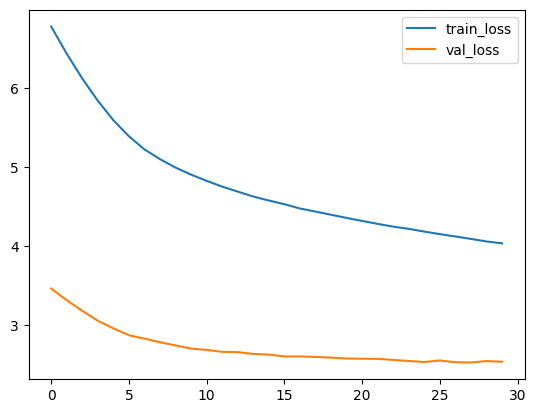

In [9]:
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.legend()
plt.show()

In [10]:
def predict_next_words(model, sentence, word2idx, idx2word, n_words=5):
    model.eval()
    words = sentence.lower().split()
    state = model.init_state(1)
    predicted_words = []
    
    # Convert state to device
    state = (state[0].to(device), state[1].to(device))
    
    # Initialize context with input sentence
    with torch.no_grad():
        # Process full input sequence
        for word in words:
            x = torch.tensor([[word2idx.get(word, 0)]]).to(device)  # Handle OOV with <unk>
            _, state = model(x, state)
        
        # Start with last word as current input
        current_word = words[-1]
        
        # Generate n_words predictions
        for _ in range(n_words):
            x = torch.tensor([[word2idx.get(current_word, 0)]]).to(device)
            output, state = model(x, state)
            
            # get probability distribution and sample
            probabilities = torch.softmax(output[0, -1], dim=-1)
            predicted_idx = torch.multinomial(probabilities, 1).item()
            current_word = idx2word[predicted_idx]
            predicted_words.append(current_word)
    
    return ' '.join(predicted_words)

# Example
sentence = "speak"
next_words = predict_next_words(model, sentence, word2idx, idx2word, n_words=5)
print(f"Next words after '{sentence}': {next_words}")

Next words after 'speak': clad comes name head, thousand


#